In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla T4


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/fish-data-raw/Fish Data raw/Fish Data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


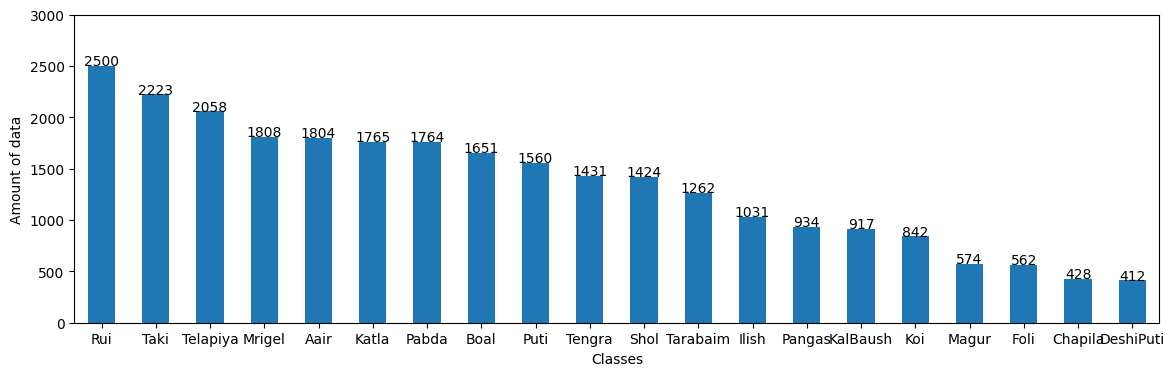

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

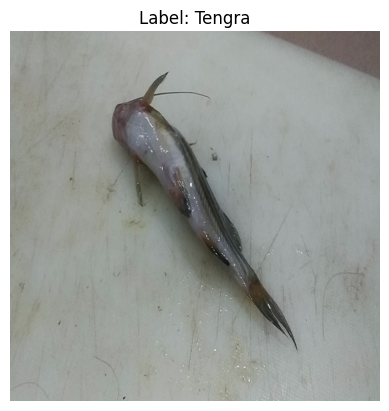

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# EfficientNet B3

In [15]:
from torchvision import models
import torch.nn as nn

total_class = 20
learning_rate = 0.0001

# Load EfficientNet-B3
model = models.efficientnet_b3(pretrained=False)

# Modify the classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, total_class)

# Move to device
model = model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Model summary
summary(model, input_size=(train_batch, 3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 20]                  --
├─Sequential: 1-1                                       [32, 1536, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 40, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 40, 112, 112]        1,080
│    │    └─BatchNorm2d: 3-2                            [32, 40, 112, 112]        80
│    │    └─SiLU: 3-3                                   [32, 40, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 24, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 24, 112, 112]        2,298
│    │    └─MBConv: 3-5                                 [32, 24, 112, 112]        1,206
│    └─Sequential: 2-3                                  [32, 32, 56, 56]          --
│    │    └─MBConv: 3-6                            

In [16]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=30, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/30: 100%|██████████| 590/590 [03:19<00:00,  2.96it/s, acc=0.232, loss=2.42]

Training Loss: 2.418 Acc: 0.232


Validation Loss: 1.566 Acc: 0.457
Best model saved at epoch 1 with validation accuracy: 0.457


Epoch 2/30: 100%|██████████| 590/590 [03:14<00:00,  3.03it/s, acc=0.52, loss=1.45] 

Training Loss: 1.450 Acc: 0.520


Validation Loss: 0.932 Acc: 0.682
Best model saved at epoch 2 with validation accuracy: 0.682


Epoch 3/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.708, loss=0.891]

Training Loss: 0.891 Acc: 0.708


Validation Loss: 0.427 Acc: 0.858
Best model saved at epoch 3 with validation accuracy: 0.858


Epoch 4/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.809, loss=0.584]

Training Loss: 0.584 Acc: 0.809


Validation Loss: 0.287 Acc: 0.901
Best model saved at epoch 4 with validation accuracy: 0.901


Epoch 5/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.868, loss=0.403]

Training Loss: 0.403 Acc: 0.868


Validation Loss: 0.201 Acc: 0.933
Best model saved at epoch 5 with validation accuracy: 0.933


Epoch 6/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.9, loss=0.309]  

Training Loss: 0.309 Acc: 0.900


Validation Loss: 0.140 Acc: 0.955
Best model saved at epoch 6 with validation accuracy: 0.955


Epoch 7/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.913, loss=0.263]

Training Loss: 0.263 Acc: 0.913


Validation Loss: 0.129 Acc: 0.957
Best model saved at epoch 7 with validation accuracy: 0.957


Epoch 8/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.937, loss=0.202]

Training Loss: 0.202 Acc: 0.937


Validation Loss: 0.096 Acc: 0.971
Best model saved at epoch 8 with validation accuracy: 0.971


Epoch 9/30: 100%|██████████| 590/590 [03:13<00:00,  3.05it/s, acc=0.943, loss=0.183]

Training Loss: 0.183 Acc: 0.943


Validation Loss: 0.084 Acc: 0.973
Best model saved at epoch 9 with validation accuracy: 0.973


Epoch 10/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.954, loss=0.145]

Training Loss: 0.145 Acc: 0.954


Validation Loss: 0.133 Acc: 0.968


Epoch 11/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.957, loss=0.136]

Training Loss: 0.136 Acc: 0.957


Validation Loss: 0.123 Acc: 0.962


Epoch 12/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.965, loss=0.111]

Training Loss: 0.111 Acc: 0.965


Validation Loss: 0.065 Acc: 0.980
Best model saved at epoch 12 with validation accuracy: 0.980


Epoch 13/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.964, loss=0.107] 

Training Loss: 0.107 Acc: 0.964


Validation Loss: 0.056 Acc: 0.980


Epoch 14/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.971, loss=0.0892]

Training Loss: 0.089 Acc: 0.971


Validation Loss: 0.066 Acc: 0.982
Best model saved at epoch 14 with validation accuracy: 0.982


Epoch 15/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.968, loss=0.1]   

Training Loss: 0.100 Acc: 0.968


Validation Loss: 0.057 Acc: 0.983
Best model saved at epoch 15 with validation accuracy: 0.983


Epoch 16/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.976, loss=0.0771]

Training Loss: 0.077 Acc: 0.976


Validation Loss: 0.111 Acc: 0.967


Epoch 17/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.978, loss=0.0698]

Training Loss: 0.070 Acc: 0.978


Validation Loss: 0.051 Acc: 0.984
Best model saved at epoch 17 with validation accuracy: 0.984


Epoch 18/30: 100%|██████████| 590/590 [03:13<00:00,  3.05it/s, acc=0.976, loss=0.075] 

Training Loss: 0.075 Acc: 0.976


Validation Loss: 0.076 Acc: 0.978


Epoch 19/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.983, loss=0.055] 

Training Loss: 0.055 Acc: 0.983


Validation Loss: 0.064 Acc: 0.981


Epoch 20/30: 100%|██████████| 590/590 [03:14<00:00,  3.03it/s, acc=0.981, loss=0.0623]

Training Loss: 0.062 Acc: 0.981


Validation Loss: 0.037 Acc: 0.988
Best model saved at epoch 20 with validation accuracy: 0.988


Epoch 21/30: 100%|██████████| 590/590 [03:14<00:00,  3.03it/s, acc=0.983, loss=0.0529]

Training Loss: 0.053 Acc: 0.983


Validation Loss: 0.047 Acc: 0.986


Epoch 22/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.98, loss=0.0637] 

Training Loss: 0.064 Acc: 0.980


Validation Loss: 0.043 Acc: 0.987


Epoch 23/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.985, loss=0.0526]

Training Loss: 0.053 Acc: 0.985


Validation Loss: 0.057 Acc: 0.984


Epoch 24/30: 100%|██████████| 590/590 [03:13<00:00,  3.04it/s, acc=0.987, loss=0.0459]

Training Loss: 0.046 Acc: 0.987


Validation Loss: 0.049 Acc: 0.987


Epoch 25/30: 100%|██████████| 590/590 [03:14<00:00,  3.04it/s, acc=0.985, loss=0.0474]

Training Loss: 0.047 Acc: 0.985


Validation Loss: 0.063 Acc: 0.981
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training Time: 5458.67 seconds ---> 90.98 minutes


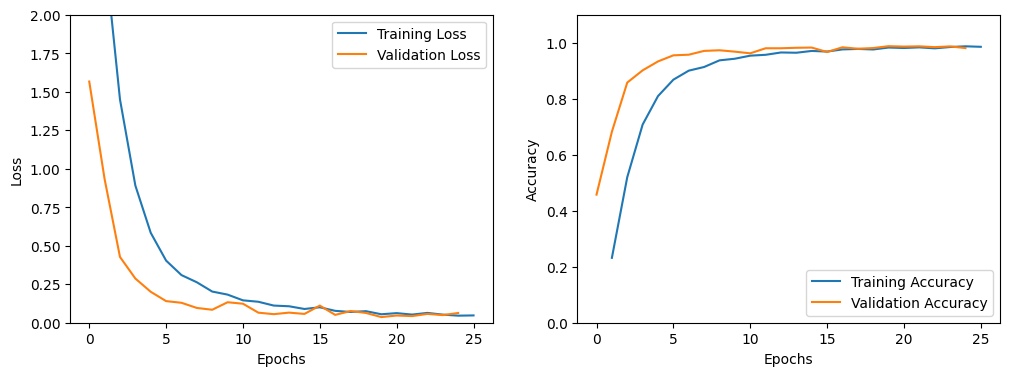

In [17]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [18]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [19]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.5f}")

Best model (from epoch 20) - Validation Loss: 0.037, Validation Accuracy: 0.98763


In [20]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.985
Test Time: 42.70 seconds ---> 0.71 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.5f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       271
           1       1.00      0.97      0.98       248
           2       0.98      1.00      0.99        64
           3       0.97      1.00      0.98        62
           4       0.99      1.00      0.99        84
           5       1.00      0.99      0.99       154
           6       0.99      0.99      0.99       137
           7       1.00      0.98      0.99       265
           8       0.99      0.98      0.99       126
           9       0.99      1.00      0.99        86
          10       0.99      0.99      0.99       272
          11       0.99      1.00      0.99       265
          12       0.99      0.99      0.99       140
          13       0.99      1.00      0.99       234
          14       0.98      0.99      0.99       375
          15       0.97      0.96      0.96       213
          16       0.97      0.97      0.97       334
    

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Use full backward hook for newer PyTorch versions
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_full_backward_hook(backward_hook)

        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[:, target_class]
        class_score.backward()

        gradients = self.gradients  # shape: [B, C, H, W]
        activations = self.activations  # shape: [B, C, H, W]
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-6)
        return cam

def show_gradcam(model, dataloader, device, target_layer, classes, num_samples=10):
    gradcam = GradCAM(model, target_layer)

    count = 0
    plt.figure(figsize=(20, 20))

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(inputs.size(0)):
            input_tensor = inputs[i].unsqueeze(0)
            label = labels[i].item()

            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

            cam = gradcam.generate_cam(input_tensor, pred_class)

            # Reverse normalization (if used): optional based on your transforms
            img_np = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
            img_np = np.uint8(255 * img_np)

            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(heatmap, 0.4, img_np, 0.6, 0)

            plt.subplot(5, 2, count + 1)
            plt.imshow(overlay)
            plt.title(f"GT: {classes[label]} | Pred: {classes[pred_class]}")
            plt.axis('off')

            count += 1
            if count == num_samples:
                plt.tight_layout()
                plt.show()
                gradcam.remove_hooks()
                return



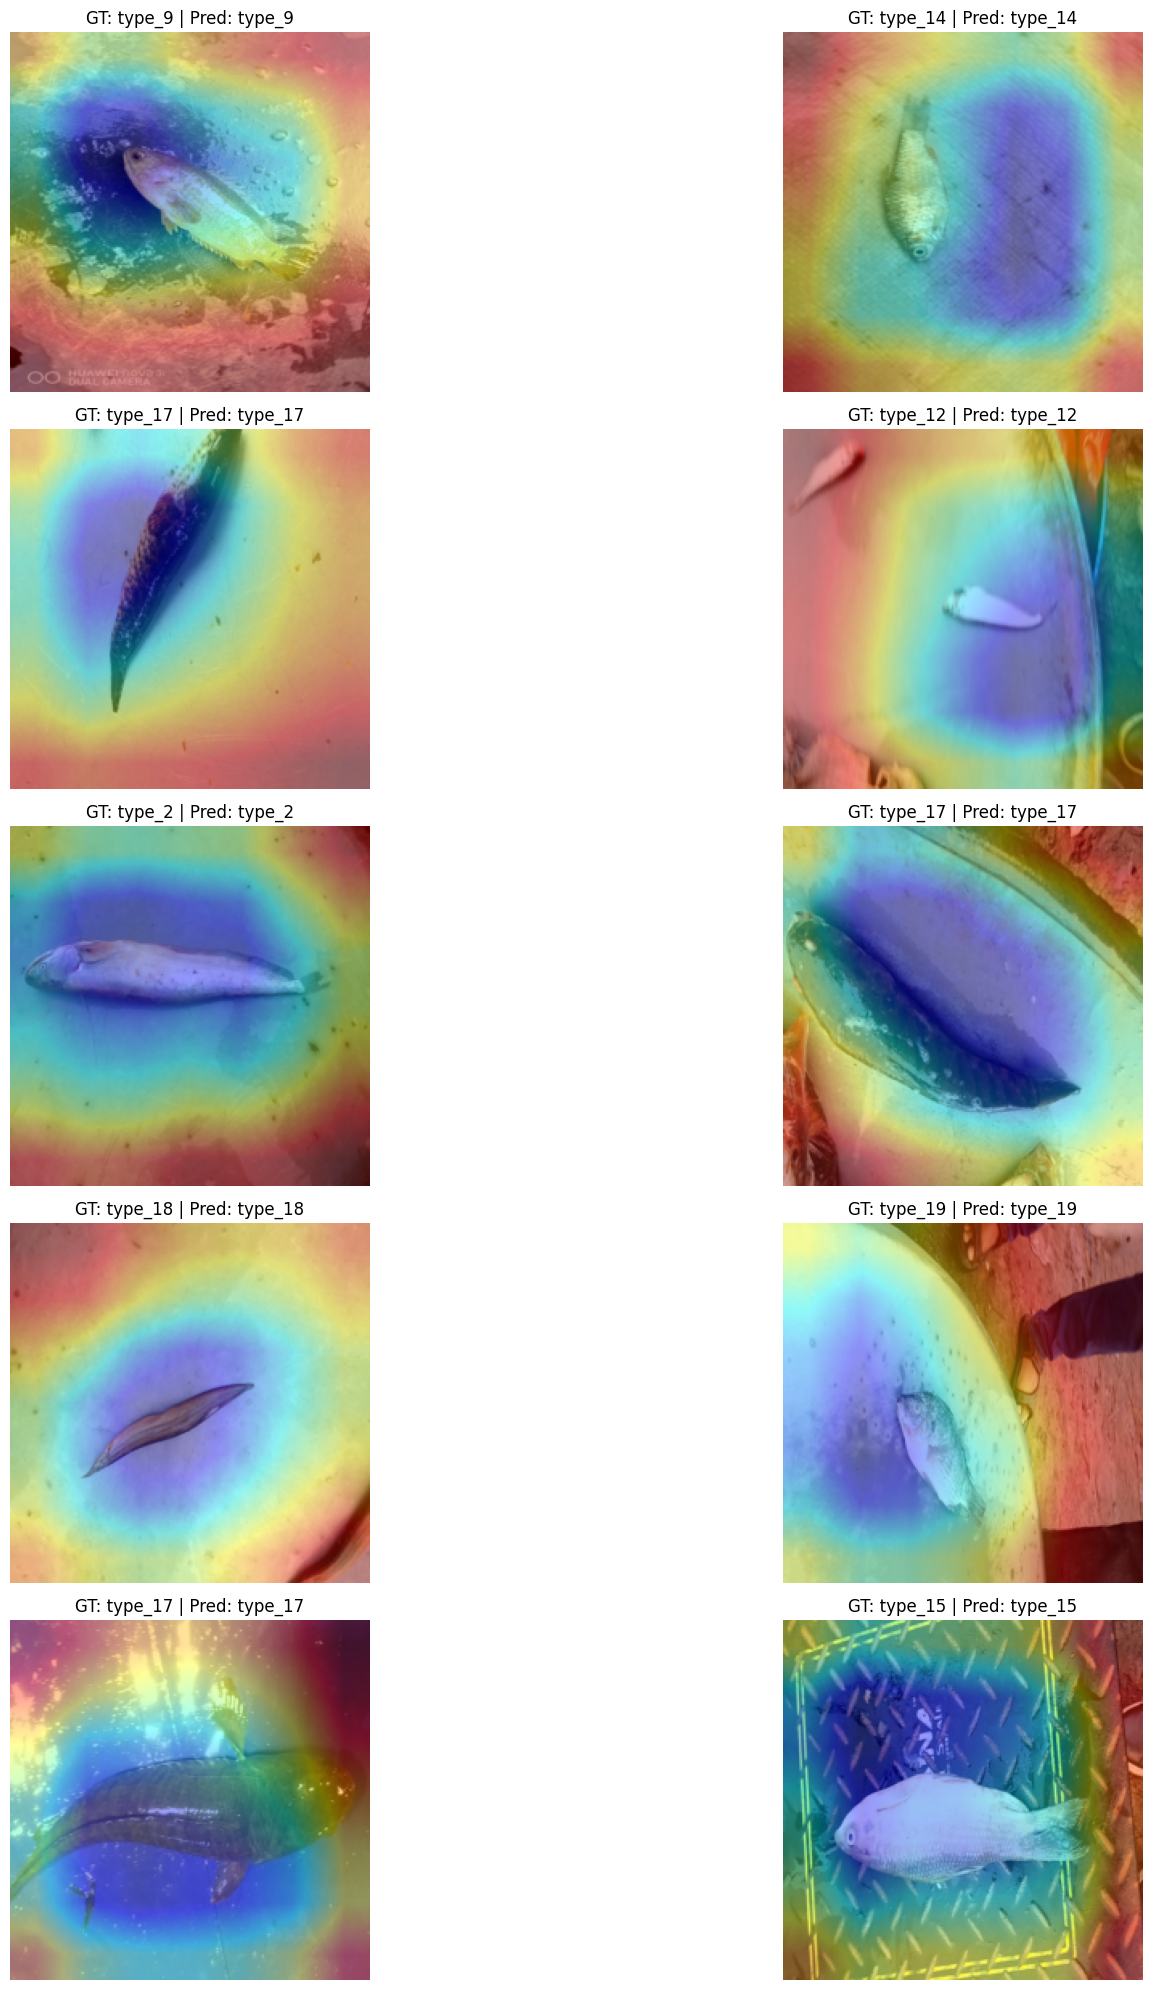

In [23]:
# EfficientNet-B3 last convolutional block
target_layer = model.features[-1]  # or model.features[8] also works

# Class names (example: fish types)
class_names = [f"type_{i}" for i in range(1, 21)]

# Call Grad-CAM
show_gradcam(model, dataloader_test_dataset, device, target_layer, class_names, num_samples=10)
